<a href="https://colab.research.google.com/github/victorcionca/nist_experiments/blob/master/sionna_kfactor_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
try:
  import sionna
except ImportError as e:
  import os
  os.system("pip install sionna")
  import sionna

In [ ]:
sionna.config.xla_compat = True

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import numpy as np
import tensorflow as tf
import time
import pickle
import pandas as pd

# Implementing a narrowband Rice channel

Same approach as the Rayleigh:
* single MPC
* the MPC is Rice distributed, where we can control the k-factor.

In [ ]:
class RiceBlockFading():
    def __init__(   self,
                    k_factor,
                    dtype=tf.complex64):
        """
        Parameters
        ==========
        k_factor    -- log-scale k-factor
        """
        assert dtype.is_complex, "'dtype' must be complex type"
        self._dtype = dtype
        self.k_factor = 10**(k_factor/10)  #linear-sacale k-factor


    def __call__(self,  batch_size, num_time_steps):
        """
        Instantiate the model.

        Parameters
        ==========
        batch_size    -- number of samples to generate
        num_time_steps-- values per sample
        k_factor      -- log-scale k-factor
        """
        # Delays
        # Single path with zero delay
        delays = tf.zeros([ batch_size,
                            1, 1, # tx/rx streams
                            1], # Single path
                            dtype=self._dtype.real_dtype)

        # Fading coefficients
        #theta = np.pi*np.random.rand()
        theta = 0
        std = tf.cast(tf.sqrt(0.5), dtype=self._dtype.real_dtype)
        niu = tf.sqrt(self.k_factor*2*std**2)
        h_real = tf.random.normal(shape=[   batch_size,
                                         1,1,1,1, # tx/rx streams
                                            1, # One path
                                            1], # Same response over the block
                                            mean=niu*np.cos(theta),
                                            stddev=std,
                                            dtype = self._dtype.real_dtype)
        h_img = tf.random.normal(shape=[    batch_size,
                                            1,1,1,1, # tx/rx streams
                                            1, # One cluster
                                            1], # Same response over the block
                                            mean=niu*np.sin(theta),
                                            stddev=std,
                                            dtype = self._dtype.real_dtype)
        h = tf.complex(h_real, h_img)
        # Tile the response over the block
        h = tf.tile(h, [1, 1, 1, 1, 1, 1, num_time_steps])
        return h, delays

# Comms system with Rice flat fading

Comms system description

* binary source
* data is transmitted in time slots containing 14 OFDM symbols
* LDPC encoded with user-defined code rate
* QAM 4 bits
* interleaving
* Rayleigh or CDL channel model - at the moment is hard-coded in the CommsSystem class
* support for ISI and ICI.

In [ ]:
class CommsSystemRiceChannel(tf.keras.Model):
  def __init__(self, params):
    super().__init__()
    #self.bandwidth = params["bandwidth"]
    # TODO: compute the fft_size and subcarrier spacing based on the bandwidth
    # Define an OFDM Resource Grid Object
    self.rg = sionna.ofdm.ResourceGrid(
                          num_ofdm_symbols=14, #params["num_ofdm_symbols"],
                          fft_size=76, #params["fft_size"],
                          subcarrier_spacing=15e3, #params["subcarrier_spacing"],
                          num_tx=1,
                          num_streams_per_tx=1,
                          cyclic_prefix_length=6,
                          num_guard_carriers=[5,6],
                          pilot_pattern="kronecker",
                          pilot_ofdm_symbol_indices=[2,11])#params["pilot_ofdm_symbol_indices"])
    self.bandwidth = self.rg.bandwidth # TODO: replace this later as user-defined

    # Create a Stream Management object
    self.sm = sionna.mimo.StreamManagement(rx_tx_association=np.array([[1]]),
                                               num_streams_per_tx=1)
    self.coderate = 0.5
    self.num_bits_per_symbol = 4
    self.n = int(self.rg.num_data_symbols*self.num_bits_per_symbol)
    self.k = int(self.n*self.coderate)

    self.l_min, self.l_max = sionna.channel.time_lag_discrete_time_channel(
                                            self.bandwidth)
    self.l_tot = self.l_max - self.l_min + 1

    # The layers of the comms system
    self.binary_source = sionna.utils.BinarySource()
    self.encoder = sionna.fec.ldpc.encoding.LDPC5GEncoder(self.k, self.n)
    #self.encoder = sionna.fec.polar.encoding.Polar5GEncoder(self.k, self.n)
    self.interleaver = sionna.fec.interleaving.RowColumnInterleaver(
                                          row_depth=self.num_bits_per_symbol)
    self.deinterleaver = sionna.fec.interleaving.Deinterleaver(self.interleaver)
    self.mapper = sionna.mapping.Mapper("qam", self.num_bits_per_symbol)
    self.rg_mapper = sionna.ofdm.ResourceGridMapper(self.rg)

    self.demapper = sionna.mapping.Demapper("app", "qam", self.num_bits_per_symbol)
    self.decoder = sionna.fec.ldpc.LDPC5GDecoder(self.encoder,
                                                 hard_out=True,
                                                 num_iter=50)
    
    self.kfactor = params["kfactor"]
    self.rice_channel = RiceBlockFading(self.kfactor)

    self.apply_ofdm = sionna.channel.ApplyOFDMChannel(add_awgn=True)

    # Channel estimation and equalization
    self.ch_est = sionna.ofdm.LSChannelEstimator(self.rg)
    self.ch_eq = sionna.ofdm.LMMSEEqualizer(self.rg, self.sm)

  #@tf.function(jit_compile=True)
  def call(self, batch_size, ebno_db):
    # Compute the noise
    no = sionna.utils.ebnodb2no(ebno_db, self.num_bits_per_symbol,
                                self.coderate, self.rg)
    # Generate the bit vectors
    b = self.binary_source([batch_size, 1, 1, self.k])
    # Encode the bits
    c = self.encoder(b)
    # Interleave
    c_int = self.interleaver(c)
    # Map to constellation symbols
    s = self.mapper(c_int)
    # Map onto OFDM resource grid
    x_rg = self.rg_mapper(s)

    # Generate CIRs from the channel
    a, tau = self.rice_channel(batch_size, self.rg.num_ofdm_symbols)

    # Determine channel freq response
    frequencies = sionna.channel.subcarrier_frequencies(self.rg.fft_size, self.rg.subcarrier_spacing)
    h_freq = sionna.channel.utils.cir_to_ofdm_channel(frequencies, a, tau)
    
    # Apply channel filter
    y = self.apply_ofdm([x_rg, h_freq, no])

    # Apply channel estimation
    h_hat, err_var = self.ch_est([y, no])
    # Apply equalization
    x_hat, no_eff = self.ch_eq([y, h_hat, err_var, no])
    # Demapping
    llr = self.demapper([x_hat, no_eff])
    # Deinterleave
    llr_int = self.deinterleaver(llr)
    # Decoding
    b_hat = self.decoder(llr_int)
    #ber = sionna.utils.metrics.compute_ber(b, b_hat)
    return b, b_hat

# Comms system with CIR dataset

In [ ]:
def sample_timesteps(cir_data, batch_size, num_timesteps, num_paths):
  a = np.ndarray((batch_size, 1, 1, 1, 1, num_paths, num_timesteps), np.complex64)
  for batch in range(batch_size):
    start_idx = np.random.randint(len(cir_data)-num_timesteps)
    paths = np.ndarray((num_timesteps, num_paths), np.complex64)
    for idx in range(num_timesteps):
      paths[idx] = cir_data[start_idx][0]
    a[batch,0,0,0,0] = np.transpose(paths)
  tau = np.ndarray((batch_size, 1, 1, num_paths), np.float32)
  for batch in range(batch_size):
    tau[batch, 0, 0] = cir_data[0][1]
  return a, tau

In [ ]:
class CommsSystemDataset(tf.keras.Model):
  def __init__(self, params):
    super().__init__()
    #self.bandwidth = params["bandwidth"]
    # TODO: compute the fft_size and subcarrier spacing based on the bandwidth
    # Define an OFDM Resource Grid Object
    self.rg = sionna.ofdm.ResourceGrid(
                          num_ofdm_symbols=14, #params["num_ofdm_symbols"],
                          fft_size=76, #params["fft_size"],
                          subcarrier_spacing=15e3, #params["subcarrier_spacing"],
                          num_tx=1,
                          num_streams_per_tx=1,
                          cyclic_prefix_length=6,
                          num_guard_carriers=[5,6],
                          pilot_pattern="kronecker",
                          pilot_ofdm_symbol_indices=[2,11])#params["pilot_ofdm_symbol_indices"])
    self.bandwidth = self.rg.bandwidth # TODO: replace this later as user-defined

    # Create a Stream Management object
    self.sm = sionna.mimo.StreamManagement(rx_tx_association=np.array([[1]]),
                                               num_streams_per_tx=1)
    self.coderate = 0.5
    self.num_bits_per_symbol = 4
    self.n = int(self.rg.num_data_symbols*self.num_bits_per_symbol)
    self.k = int(self.n*self.coderate)

    self.l_min, self.l_max = sionna.channel.time_lag_discrete_time_channel(
                                            self.bandwidth)
    self.l_tot = self.l_max - self.l_min + 1

    # The layers of the comms system
    self.binary_source = sionna.utils.BinarySource()
    self.encoder = sionna.fec.ldpc.encoding.LDPC5GEncoder(self.k, self.n)
    #self.encoder = sionna.fec.polar.encoding.Polar5GEncoder(self.k, self.n)
    self.interleaver = sionna.fec.interleaving.RowColumnInterleaver(
                                          row_depth=self.num_bits_per_symbol)
    self.deinterleaver = sionna.fec.interleaving.Deinterleaver(self.interleaver)
    self.mapper = sionna.mapping.Mapper("qam", self.num_bits_per_symbol)
    self.rg_mapper = sionna.ofdm.ResourceGridMapper(self.rg)

    self.demapper = sionna.mapping.Demapper("app", "qam", self.num_bits_per_symbol)
    self.decoder = sionna.fec.ldpc.LDPC5GDecoder(self.encoder,
                                                 hard_out=True,
                                                 num_iter=50)
    
    self.cir_data = params["cir_data"]
    self.cir_taps = params.get("num_taps", 50)

    self.apply_ofdm = sionna.channel.ApplyOFDMChannel(add_awgn=True)

    # Channel estimation and equalization
    self.ch_est = sionna.ofdm.LSChannelEstimator(self.rg)
    self.ch_eq = sionna.ofdm.LMMSEEqualizer(self.rg, self.sm)

  #@tf.function(jit_compile=True)
  def call(self, batch_size, ebno_db):
    # Compute the noise
    no = sionna.utils.ebnodb2no(ebno_db, self.num_bits_per_symbol,
                                self.coderate, self.rg)
    # Generate the bit vectors
    b = self.binary_source([batch_size, 1, 1, self.k])
    # Encode the bits
    c = self.encoder(b)
    # Interleave
    c_int = self.interleaver(c)
    # Map to constellation symbols
    s = self.mapper(c_int)
    # Map onto OFDM resource grid
    x_rg = self.rg_mapper(s)

    # Sample a batch of CIRs from the dataset
    cirs = sample_timesteps(self.cir_data, batch_size, self.rg.num_ofdm_symbols, self.cir_taps)
    # Determine channel freq response
    frequencies = sionna.channel.subcarrier_frequencies(self.rg.fft_size, self.rg.subcarrier_spacing)
    h_freq = sionna.channel.utils.cir_to_ofdm_channel(frequencies, *cirs, normalize=True)

    y = self.apply_ofdm([x_rg, h_freq, no])

    # Apply channel estimation
    h_hat, err_var = self.ch_est([y, no])
    # Apply equalization
    x_hat, no_eff = self.ch_eq([y, h_hat, err_var, no])
    # Demapping
    llr = self.demapper([x_hat, no_eff])
    # Deinterleave
    llr_int = self.deinterleaver(llr)
    # Decoding
    b_hat = self.decoder(llr_int)
    #ber = sionna.utils.metrics.compute_ber(b, b_hat)
    return b, b_hat

In [ ]:
class CommsSystemDatasetExp(tf.keras.Model):
  def __init__(self, params):
    super().__init__()
    #self.bandwidth = params["bandwidth"]
    # TODO: compute the fft_size and subcarrier spacing based on the bandwidth
    # Define an OFDM Resource Grid Object
    self.rg = sionna.ofdm.ResourceGrid(
                          num_ofdm_symbols=14, #params["num_ofdm_symbols"],
                          fft_size=76, #params["fft_size"],
                          subcarrier_spacing=15e3, #params["subcarrier_spacing"],
                          num_tx=1,
                          num_streams_per_tx=1,
                          cyclic_prefix_length=6,
                          num_guard_carriers=[5,6],
                          pilot_pattern="kronecker",
                          pilot_ofdm_symbol_indices=[2,11])#params["pilot_ofdm_symbol_indices"])
    self.bandwidth = self.rg.bandwidth # TODO: replace this later as user-defined

    # Create a Stream Management object
    self.sm = sionna.mimo.StreamManagement(rx_tx_association=np.array([[1]]),
                                               num_streams_per_tx=1)
    self.coderate = 0.5
    self.num_bits_per_symbol = 4
    self.n = int(self.rg.num_data_symbols*self.num_bits_per_symbol)
    self.k = int(self.n*self.coderate)

    self.l_min, self.l_max = sionna.channel.time_lag_discrete_time_channel(
                                            self.bandwidth)
    self.l_tot = self.l_max - self.l_min + 1

    # The layers of the comms system
    self.binary_source = sionna.utils.BinarySource()
    self.encoder = sionna.fec.ldpc.encoding.LDPC5GEncoder(self.k, self.n)
    #self.encoder = sionna.fec.polar.encoding.Polar5GEncoder(self.k, self.n)
    self.interleaver = sionna.fec.interleaving.RowColumnInterleaver(
                                          row_depth=self.num_bits_per_symbol)
    self.deinterleaver = sionna.fec.interleaving.Deinterleaver(self.interleaver)
    self.mapper = sionna.mapping.Mapper("qam", self.num_bits_per_symbol)
    self.rg_mapper = sionna.ofdm.ResourceGridMapper(self.rg)

    self.demapper = sionna.mapping.Demapper("app", "qam", self.num_bits_per_symbol)
    self.decoder = sionna.fec.ldpc.LDPC5GDecoder(self.encoder,
                                                 hard_out=True,
                                                 num_iter=50)
    
    self.cir_data = params["cir_data"]
    self.batch_size = params["batch_size"]

    self.cir_gen = CIRGenerator(self.cir_data, num_paths=50,
                              num_ofdm_syms=self.rg.num_ofdm_symbols) # In freq domain num time steps equal to num ofdm symbols
    self.cir_chmodel = sionna.channel.CIRDataset(self.cir_gen, self.batch_size,
                                                 1, 1, 1, 1, 50,
                                                 self.rg.num_ofdm_symbols)
    self.cir_freqchannel = sionna.channel.OFDMChannel(self.cir_chmodel,
                                                      self.rg,
                                                      normalize_channel=True,
                                                      return_channel=False)
  
    # Channel estimation and equalization
    self.ch_est = sionna.ofdm.LSChannelEstimator(self.rg)
    self.ch_eq = sionna.ofdm.LMMSEEqualizer(self.rg, self.sm)

  @tf.function(jit_compile=False)
  def call(self, batch_size, ebno_db):
    # Compute the noise
    no = sionna.utils.ebnodb2no(ebno_db, self.num_bits_per_symbol,
                                self.coderate, self.rg)
    # Generate the bit vectors
    b = self.binary_source([batch_size, 1, 1, self.k])
    # Encode the bits
    c = self.encoder(b)
    # Interleave
    c_int = self.interleaver(c)
    # Map to constellation symbols
    s = self.mapper(c_int)
    # Map onto OFDM resource grid
    x_rg = self.rg_mapper(s)

    y = self.cir_freqchannel([x_rg, no])

    # Apply channel estimation
    h_hat, err_var = self.ch_est([y, no])
    # Apply equalization
    x_hat, no_eff = self.ch_eq([y, h_hat, err_var, no])
    # Demapping
    llr = self.demapper([x_hat, no_eff])
    # Deinterleave
    llr_int = self.deinterleaver(llr)
    # Decoding
    b_hat = self.decoder(llr_int)
    #ber = sionna.utils.metrics.compute_ber(b, b_hat)
    return b, b_hat

# Validation

The results of the optimization are validated on the measurement-based channel.

The obtained optimal polar code configurations are tested on the measurement-based channel at the respective SNR. The results will be compared in achieved BER at 35dB

The validation is for the accuracy of the k-factor estimation. Since we don't know what the _actual_ k-factor is, we cannot directly measure the accuracy. However, we can indirectly measure it through the performance of the communication link: the performance is evaluated on the measurement-based channel and compared with that of a simulated channel configured with the estimated k factor. The differences between the two will be caused by:
* the differences in the model, such as flat fading (theoretical) vs selective fading (measurements)
* the difference between the estimated and actual k factor.

### Validation setup

First validate using the mean estimated k-factor from an entire measurement run. As shown below, the k-factor varies significantly during the measurement run as the receiver moves through the environment. Therefore the are regions where the estimated (and likely actual) k-factor differs significantly from the mean. We expect, and the validation below confirms that the performance on the measurement-based channel will be different from the predicted one.

The second evaluation isolates regions from the measurement run where the estimated k-factor is very close to the mean. We expect that the performance in the measurement-based channel will be more similar to the predicted.

## Data

CIR data based on NIST measurements.

Each CIR is stored as
* path coefficients
* path delays

In [ ]:
from shutil import rmtree
import os
if os.path.exists("nist_experiments"):
  rmtree("nist_experiments")
!git clone -b master https://github.com/victorcionca/nist_experiments.git

Cloning into 'nist_experiments'...
remote: Enumerating objects: 64, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 64 (delta 18), reused 53 (delta 10), pack-reused 0
Unpacking objects: 100% (64/64), done.


In [ ]:
cir_iq_data = pickle.load(open('nist_experiments/PDP__GBurgD2_5GHz_TX2high_crossPol_pp_all_taps.pickle', 'rb'))

In [ ]:
nist_tx2low = pickle.load(open('nist_experiments/PDP__GBurgD2_5GHz_TX2low_vpol_run1_allpoints.pickle', 'rb'))

In [ ]:
len(cir_iq_data)

12000

What is the minimum number of paths per CIR?

(array([    0.,     0.,     0.,     0.,     0., 12000.,     0.,     0.,
            0.,     0.]),
 array([49.5, 49.6, 49.7, 49.8, 49.9, 50. , 50.1, 50.2, 50.3, 50.4, 50.5]),
 <a list of 10 Patch objects>)

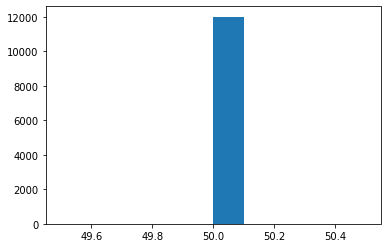

In [ ]:
plt.hist([len(paths) for paths, delays in cir_iq_data])

#### K factor estimates

In [ ]:
import pandas as pd

In [ ]:
kfactors = pd.read_csv('nist_experiments/K-Factor04-GBurgD2_5GHz_TX2high_crossPol_pp__channel_stats.mat.csv', header=None)
kfactors.columns = ['MoM', 'SM', 'FM', 'samples', 'idx_start', 'idx_end', 'no']
del kfactors['no']

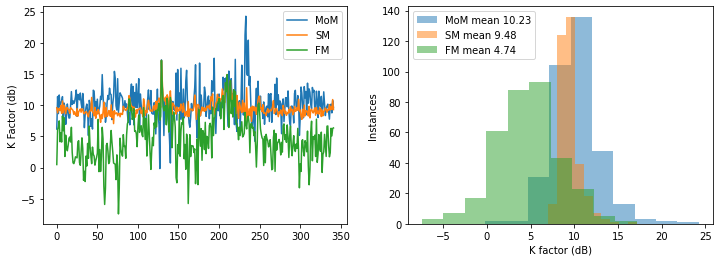

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
ax[0].plot(kfactors['MoM'], label='MoM')
ax[0].plot(kfactors['SM'], label='SM')
ax[0].plot(kfactors['FM'], label='FM')
ax[0].legend()
ax[0].set_ylabel('K Factor (db)')
ax[1].hist(kfactors['MoM'], alpha=0.5, label='MoM mean {0:.2f}'.format(np.mean(kfactors['MoM'])))
ax[1].hist(kfactors['SM'], alpha=0.5, label='SM mean {0:.2f}'.format(np.mean(kfactors['SM'])))
ax[1].hist(kfactors['FM'], alpha=0.5, label='FM mean {0:.2f}'.format(np.mean(kfactors['FM'])))
ax[1].set_ylabel('Instances')
ax[1].set_xlabel('K factor (dB)')
ax[1].legend()

The figure shows the K factors determined with the three estimators (Narrowband Method of Moments, Wideband Strongest over Mean, Wideband First over Mean), _over the entire measurement run_. In some cases there is variation of greater than 10dB in the data.

Retrieve CIR samples from 10-lambda windows that have a target k factor.

In [ ]:
def get_kfactor_regions(target_kfactor, kfactor_trace):
  """
  From the trace of k factors returns the regions where the difference between
  the data and the target is < .5.
  The regions are returned as (idx_start, idx_end).
  
  Parameters
  ==========
  target_kfactor    -- The target value of the k factor.
  kfactor_trace     -- Pandas data frame with three columns: k-factor, idx start, idx end.
  """
  kfactor_col = kfactor_trace.columns[0]
  data = kfactor_trace[abs(kfactor_trace[kfactor_col] - target_kfactor) < 0.5]
  return zip(data['idx_start'], data['idx_end'])

In [ ]:
from itertools import chain

In [ ]:
def get_CIR_samples_for_regions(cir_data, regions):
  """Concatenates the CIR samples from the given regions into a list"""
  return list(chain(*[cir_data[start:end] for start, end in regions]))

In [ ]:
regions = list(get_kfactor_regions(8.5, kfactors[['MoM', 'idx_start', 'idx_end']]))

In [ ]:
cirs = get_CIR_samples_for_regions(cir_iq_data, regions)

In [ ]:
len(cirs)

1253

### Region-based k factor comparison

For k factor regions (groups of 10-lambda windows that have the same k factor) analyse the average CIRs.

#### TX2 high

In [ ]:
mom_low_regions = list(get_kfactor_regions(5, kfactors[['MoM', 'idx_start', 'idx_end']]))

In [ ]:
mom_low_cirs = get_CIR_samples_for_regions(cir_iq_data, mom_low_regions)

In [ ]:
len(mom_low_cirs)

95

In [ ]:
def get_avg_cir(cir_samples):
  return np.mean(list(zip(*cir_samples))[0], axis=0)

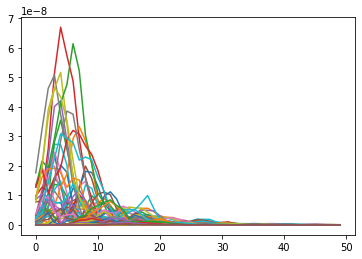

In [ ]:
plt.plot(abs(get_avg_cir(mom_low_cirs))**2)
for cir, delays in mom_low_cirs:
  plt.plot(abs(cir)**2)

In [ ]:
mom_high_regions = list(get_kfactor_regions(13, kfactors[['MoM', 'idx_start', 'idx_end']]))
mom_high_cirs = get_CIR_samples_for_regions(cir_iq_data, mom_high_regions)
len(mom_high_cirs)

264

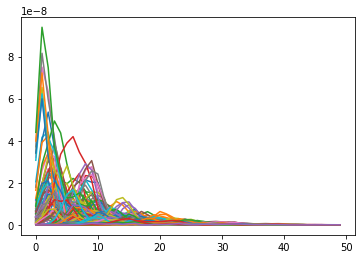

In [ ]:
plt.plot(abs(get_avg_cir(mom_high_cirs))**2)
for cir, delays in mom_high_cirs:
  plt.plot(abs(cir)**2)

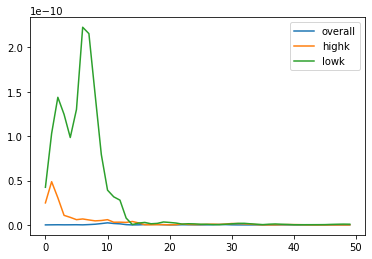

In [ ]:
plt.plot(abs(get_avg_cir(cir_iq_data))**2, label='overall')
plt.plot(abs(get_avg_cir(mom_high_cirs))**2, label='highk')
plt.plot(abs(get_avg_cir(mom_low_cirs))**2, label='lowk')
plt.legend()

### Normalize the CIR paths

``cir_iq_data`` is a list of CIRs, where each CIt is a tuple of (path amplitudes, path delays). The path amplitudes of each CIR must be normalized so they sum up to unit power.

In [ ]:
cir_iq_data[0]

(array([-0.5820486 -0.09703759j, -0.02357805+0.999722j  ,
        -0.63894881-0.02959833j,  0.20010399+0.13008325j,
         0.15166436+0.11156965j]),
 array([8.750e-08, 1.500e-07, 3.625e-07, 4.250e-07, 5.250e-07]))

In [ ]:
def normalize_cirs(cir_samples):
  normalized_cirs = []
  for cir_paths, cir_delays in cir_samples:
    if len(cir_delays) == 0: continue
    if max(cir_delays) > 1e-5: continue
    normalized_cirs.append((cir_paths/np.sqrt(sum(cir_paths**2)), cir_delays))
  return normalized_cirs

### Creating an average CIR

The average CIR will be represented as follows:
* have the union of taps from the path delays
* each tap will store the average of paths at that tap.

We might have to create bins for the taps.

In [ ]:
avg_cir_taps = {}
size_taps = {}
for paths, delays in cir_iq_data:
  for p, d in zip(paths, delays):
    if d > 1e-5: continue
    if d not in avg_cir_taps:
      avg_cir_taps[d] = 0
      size_taps[d] = 0
    else:
      avg_cir_taps[d] += abs(p)**2
      size_taps[d] += 1

Normalize the CIR

In [ ]:
max_power = max(avg_cir_taps.values())
for d, p in avg_cir_taps.items():
  avg_cir_taps[d] = p/max_power

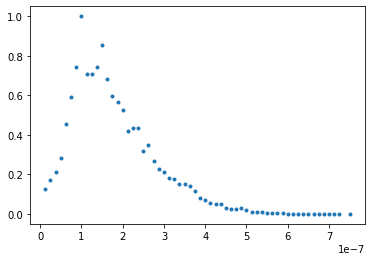

In [ ]:
plt.plot(list(avg_cir_taps.keys()), list(avg_cir_taps.values()), '.')

Create a sorted PDP containing tuples (delay, power).

In [ ]:
pdp_vals = list(avg_cir_taps.items())
pdp_vals.sort()

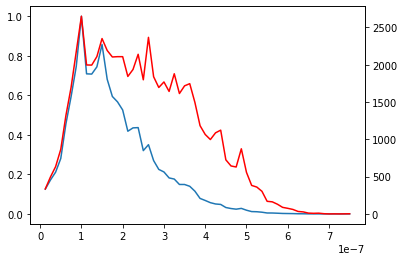

In [ ]:
plt.plot(list(zip(*pdp_vals))[0], list(zip(*pdp_vals))[1])
ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.plot(list(zip(*pdp_vals))[0], [size_taps[t] for t in list(zip(*pdp_vals))[0]], 'r')

### Impact of CP to prevent self-interference

The CP is added to prevent self-interference from a previous symbol that arrives late due to multi-path propagation.

When receiving a symbol $S_i$ we have
* energy from the symbol $S_i$
* energy from the MPCs of $S_{i-1}$.

The CP of length $T_{CP}$ is inserted at the start of the symbol. Therefore, the first $T_{CP}$ of the CIR $h(t)$ is considered usable power (signal can be recovered through equalization), whereas the remainder of the delay spread $\tau - T_{CP}$ is interference.


In [ ]:
def self_sir(cir, t_cp):
  """
  Computes the self SIR caused by inter-symbol interference,
  for the given CIR and CP length.
  
  Parameters:
  cir   -- list of (delay, power) tuples
  t_cp  -- in microseconds
  """
  usable, interf = 0,0
  for (d, p) in cir:
    if d <= t_cp: usable += p
    else: interf += p
  return 10*np.log10(usable/interf)

In [ ]:
def self_sir_linear(cir, t_cp):
  """
  Computes the self SIR caused by inter-symbol interference,
  for the given CIR and CP length.
  
  Parameters:
  cir   -- list of (delay, power) tuples
  t_cp  -- in microseconds

  Returns:
  SIR in linear scale
  """
  usable, interf = 0,0
  for (d, p) in cir:
    if d <= t_cp: usable += p
    else: interf += p
  return usable/interf

In [ ]:
sample_time = 1/200000000

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  


Text(0, 0.5, 'SIR (dB)')

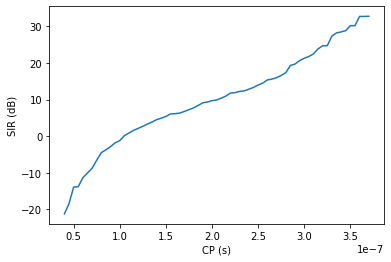

In [ ]:
t_cp = [sample_time*n for n in range(100)]
sirs = [self_sir(pdp_vals, t) for t in t_cp]
plt.plot(t_cp, sirs)
plt.xlabel('CP (s)')
plt.ylabel('SIR (dB)')

Signal to Echo plus Noise (SENR approx SNR)

In [ ]:
def senr(cir, t_cp, bw):
  """
  Calculates the SENR for the CIR and CP length
  """
  # Values below are in dB
  Pt = 20
  PL = -85 # at 50m
  Pt_lin = (Pt/10)**10*1e-3
  PL_lin = (PL/10)**10*1e-3
  sir_lin = self_sir_linear(cir, t_cp)
  noise = 1.3803e-23*290*bw
  print(Pt_lin, PL_lin, noise, noise**2)
  senr_lin = (Pt_lin*PL_lin*(sir_lin/(1+sir_lin)))/(Pt_lin*PL_lin/(1+sir_lin) + noise**2)
  return 10*np.log10(senr_lin)

In [ ]:
print(senr(pdp_vals, 15*sample_time, 200e6))
print(self_sir(pdp_vals, 15*sample_time))
print(self_sir_linear(pdp_vals, 15*sample_time))

1.024 1968744.0434072267 8.005740000000001e-13 6.409187294760001e-25
-6.563684120363826
-6.563684120363826
0.22061324766945098


In [ ]:
t_cp = [sample_time*n for n in range(100)]
senrs = [senr(pdp_vals, t, 200e6) for t in t_cp]
plt.plot(t_cp, senrs)
plt.plot(t_cp, sirs)
plt.xlabel('CP (s)')
plt.ylabel('SENR (dB)')

## Testing dataset channel

Dataset channel is seen to lead to very poor BER. This investigates why.

We look at the CIR as generated by the TimeChannel when using dataset.

In [ ]:
a, tau = sample_timesteps(cir_iq_data, 1, 2, 50)

NameError: ignored

In [ ]:
type(tau[0][0][0][0])

numpy.float32

### Testing LDPC-based comms in freq domain with default RG

In [ ]:
model = CommsSystemDataset(params={"cir_data":cir_iq_data, 'batch_size':256})

OFDM syms=14. Time steps=None


In [ ]:
ldpc_ber, lpdc_bler = sionna.utils.sim_ber(model, range(15), batch_size=256,
                                          max_mc_iter=1000, num_target_bit_errors=500)

In [ ]:
model = CommsSystemDataset(params={"cir_data":nist_tx2low})
tx2low_ldpc_ber, tx2low_lpdc_bler = sionna.utils.sim_ber(model, range(15), batch_size=256,
                                          max_mc_iter=1000, num_target_bit_errors=500)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 3.4958e-01 | 1.0000e+00 |      139607 |      399360 |          256 |         256 |         9.4 |reached target bit errors
      1.0 | 3.2984e-01 | 1.0000e+00 |      131723 |      399360 |          256 |         256 |         9.0 |reached target bit errors
      2.0 | 3.0445e-01 | 1.0000e+00 |      121587 |      399360 |          256 |         256 |         8.9 |reached target bit errors
      3.0 | 2.7989e-01 | 1.0000e+00 |      111778 |      399360 |          256 |         256 |         9.1 |reached target bit errors
      4.0 | 2.4820e-01 | 1.0000e+00 |       99122 |      399360 |          256 |         256 |         9.0 |reached target bit errors
      5.0 | 2.1782e-01 | 1.0000e+00 |       86990 |      399360 |          

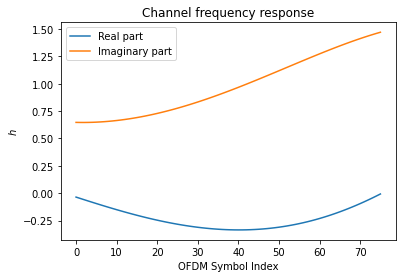

In [ ]:
plt.figure()
plt.title("Channel frequency response")
plt.plot(np.real(h_freq[0,0,0,0,0,0,:]))
plt.plot(np.imag(h_freq[0,0,0,0,0,0,:]))
plt.xlabel("OFDM Symbol Index")
plt.ylabel(r"$h$")
plt.legend(["Real part", "Imaginary part"]);

## Validation on simulated channel

Use the mean of the estimates k-factors

In [ ]:
k_factor_est_means = {est:np.mean(kfactors[est]) for est in ['MoM', 'SM', 'FM']}
print(k_factor_est_means)

{'MoM': 10.226126718213067, 'SM': 9.482427186062738, 'FM': 4.741587743179509}


In [ ]:
sim_channel_ber = {}
for estimator, kfactor in k_factor_est_means.items():
  print(f"Evaluating for {estimator}, {kfactor:.02f}")
  model = CommsSystemRiceChannel(params={"kfactor":kfactor})
  ber, _ = sionna.utils.sim_ber(model, range(15), batch_size=256,
                                          max_mc_iter=1000, num_target_bit_errors=500)
  sim_channel_ber[estimator] = ber

Evaluating for MoM, 10.23
EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 5.8218e-03 | 3.1250e-02 |        2325 |      399360 |            8 |         256 |         6.8 |reached target bit errors
      1.0 | 7.0788e-03 | 3.5156e-02 |        2827 |      399360 |            9 |         256 |         0.1 |reached target bit errors
      2.0 | 2.2261e-03 | 1.1719e-02 |         889 |      399360 |            3 |         256 |         0.1 |reached target bit errors
      3.0 | 8.2382e-04 | 3.9062e-03 |         987 |     1198080 |            3 |         768 |         0.2 |reached target bit errors
      4.0 | 2.6342e-04 | 1.5625e-03 |         526 |     1996800 |            2 |        1280 |         0.3 |reached target bit errors
      5.0 | 1.6743e-04 | 7.8125e-04 |        1003

In [ ]:
plt.errorbar([1,2,3], [np.mean(list(zip(*bers))[0]) for key, bers in sim_channel_ber.items()],
             yerr=[np.std(list(zip(*bers))[0]) for key, bers in sim_channel_ber.items()], fmt='o')
plt.yscale('log')
_=plt.xticks([1,2,3], sim_channel_ber.keys())
plt.grid(axis='y', which='major')

TypeError: ignored

## Validation on matching regions

Validate only on CIR samples from 10-lambda windows that match the target k factor.

The challenge is selecting regions that reflect the difference in estimation. That is, selecting all CIRs from regions that have k factor $k_{MoM}$ as estimated by MoM will correspond to CIRs that have significantly different $k_{FM}$.

We will select a k-factor value that is common to all estimators, and based on the histogram above that seems to be about 8dB. We then select the 8dB regions for all estimators and evaluate therein.

Now we don't have a ground truth anymore (since we have distinct regions).
We also compare with the Rice channel model with same k factor.

Find the k factor that is most common among all estimators.

In [ ]:
k_factor_range = (
    kfactors[['MoM', 'SM', 'FM']].min().min(),
    kfactors[['MoM', 'SM', 'FM']].max().max()
)

In [ ]:
k_factor_bins = np.arange(*k_factor_range, step=0.5)

In [ ]:
mom_hist = np.histogram(kfactors['MoM'], bins=k_factor_bins)
sm_hist = np.histogram(kfactors['SM'], bins=k_factor_bins)
fm_hist = np.histogram(kfactors['FM'], bins=k_factor_bins)

In [ ]:
est_hists = [(idx, sum([a,b,c])) if a*b*c != 0 else (idx, 0)
            for idx, (a,b,c) in enumerate(zip(mom_hist[0], sm_hist[0], fm_hist[0]))]

In [ ]:
est_hists.sort(key=lambda x:x[1],reverse=True)

In [ ]:
common_k_factor = k_factor_bins[est_hists[0][0]]

In [ ]:
common_k_factor

9.08578830453847

### MoM

In [ ]:
mom_cirs = get_CIR_samples_for_regions(cir_iq_data,
                  get_kfactor_regions(common_k_factor, kfactors[['MoM', 'idx_start', 'idx_end']]))

In [ ]:
len(mom_cirs)

2121

First single SNR with 5 iterations

In [ ]:
model = CommsSystemDataset(params={"cir_data":mom_cirs})
tx2high_regions_mom_ldpc_ber, _ = sionna.utils.sim_ber(model, range(15), batch_size=256,
                                          max_mc_iter=1000, num_target_bit_errors=500)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 3.5307e-01 | 1.0000e+00 |      141004 |      399360 |          256 |         256 |         9.0 |reached target bit errors
      1.0 | 3.3031e-01 | 1.0000e+00 |      131912 |      399360 |          256 |         256 |         9.0 |reached target bit errors
      2.0 | 3.0346e-01 | 1.0000e+00 |      121188 |      399360 |          256 |         256 |         9.7 |reached target bit errors
      3.0 | 2.7856e-01 | 1.0000e+00 |      111247 |      399360 |          256 |         256 |        13.1 |reached target bit errors
      4.0 | 2.5110e-01 | 1.0000e+00 |      100280 |      399360 |          256 |         256 |        12.2 |reached target bit errors
      5.0 | 2.1753e-01 | 1.0000e+00 |       86872 |      399360 |          

In [ ]:
tx2high_regions_mom_ldpc_ber = [3.5307e-01, 3.3031e-01, 3.0346e-01, 2.7856e-01, 2.5110e-01, 2.1753e-01, 1.7552e-01, 4.7691e-02, 1.5512e-02, 4.8327e-03, 6.4954e-03, 2.1134e-03, 7.9961e-04, 2.0376e-04, 7.7872e-06]

In [ ]:
mom_regions_validation_tput

[15100.875518836703,
 15295.679935108814,
 15282.05466195673,
 15521.676091227851,
 15388.292521951009]

### Strongest over Mean

In [ ]:
sm_cirs = get_CIR_samples_for_regions(cir_iq_data,
                  get_kfactor_regions(common_k_factor, kfactors[['SM', 'idx_start', 'idx_end']]))

In [ ]:
len(sm_cirs)

5388

SNR range without iterations

In [ ]:
model = CommsSystemDataset(params={"cir_data":sm_cirs})
tx2high_regions_sm_ldpc_ber, _ = sionna.utils.sim_ber(model, range(15), batch_size=256,
                                          max_mc_iter=1000, num_target_bit_errors=500)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 3.5273e-01 | 1.0000e+00 |      140866 |      399360 |          256 |         256 |        13.3 |reached target bit errors
      1.0 | 3.2943e-01 | 1.0000e+00 |      131562 |      399360 |          256 |         256 |         5.5 |reached target bit errors
      2.0 | 3.0452e-01 | 1.0000e+00 |      121613 |      399360 |          256 |         256 |         5.6 |reached target bit errors
      3.0 | 2.8243e-01 | 1.0000e+00 |      112791 |      399360 |          256 |         256 |         5.2 |reached target bit errors
      4.0 | 2.5157e-01 | 1.0000e+00 |      100468 |      399360 |          256 |         256 |         5.2 |reached target bit errors
      5.0 | 2.1787e-01 | 1.0000e+00 |       87007 |      399360 |          

KeyboardInterrupt: ignored

In [ ]:
if 'tx2high_regions_sm_ldpc_ber' not in locals():
  tx2high_regions_sm_ldpc_ber = [3.5234e-01, 3.3202e-01, 3.0491e-01, 2.8323e-01, 2.5214e-01, 2.1726e-01, 1.7086e-01, 4.5996e-02, 1.3174e-02, 8.9894e-03, 5.4262e-03, 1.3572e-03, 4.8014e-04, 2.0470e-04, 1.5966e-05]

### First over Mean

In [ ]:
fm_cirs = get_CIR_samples_for_regions(cir_iq_data,
                  get_kfactor_regions(common_k_factor, kfactors[['FM', 'idx_start', 'idx_end']]))

In [ ]:
len(fm_cirs)

229

SNR range without iterations

In [ ]:
model = CommsSystemDataset(params={"cir_data":fm_cirs})
tx2high_regions_fm_ldpc_ber, _ = sionna.utils.sim_ber(model, range(15), batch_size=256,
                                          max_mc_iter=1000, num_target_bit_errors=500)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 3.5177e-01 | 1.0000e+00 |      140481 |      399360 |          256 |         256 |         8.9 |reached target bit errors
      1.0 | 3.2861e-01 | 1.0000e+00 |      131235 |      399360 |          256 |         256 |         8.8 |reached target bit errors
      2.0 | 3.0475e-01 | 1.0000e+00 |      121703 |      399360 |          256 |         256 |         8.8 |reached target bit errors
      3.0 | 2.7668e-01 | 1.0000e+00 |      110494 |      399360 |          256 |         256 |         8.8 |reached target bit errors
      4.0 | 2.4901e-01 | 1.0000e+00 |       99445 |      399360 |          256 |         256 |         8.8 |reached target bit errors
      5.0 | 2.1888e-01 | 1.0000e+00 |       87410 |      399360 |          

KeyboardInterrupt: ignored

In [ ]:
if tx2high_regions_fm_ldpc_ber is None:
  tx2high_regions_fm_ldpc_ber = [3.5177e-01, 3.2861e-01, 3.0475e-01, 2.7668e-01, 2.4901e-01, 2.1888e-01, 1.7103e-01, 4.6737e-02, 1.5517e-02, 4.6199e-03, 3.4731e-03, 6.2976e-04, 8.2602e-06, 0, 0]

### Simulated channel

In [ ]:
model = CommsSystemRiceChannel(params={"kfactor":common_k_factor})
tx2high_regions_sim_ldpc_ber, _ = sionna.utils.sim_ber(model, range(15), batch_size=256,
                                          max_mc_iter=1000, num_target_bit_errors=500)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 2.2211e-02 | 1.1719e-01 |        8870 |      399360 |           30 |         256 |         6.8 |reached target bit errors
      1.0 | 2.0455e-02 | 1.0156e-01 |        8169 |      399360 |           26 |         256 |         0.1 |reached target bit errors
      2.0 | 1.2630e-02 | 5.8594e-02 |        5044 |      399360 |           15 |         256 |         0.1 |reached target bit errors
      3.0 | 3.5357e-03 | 2.3438e-02 |        1412 |      399360 |            6 |         256 |         0.1 |reached target bit errors
      4.0 | 3.1275e-03 | 1.1719e-02 |        1249 |      399360 |            3 |         256 |         0.1 |reached target bit errors
      5.0 | 2.2498e-03 | 1.1719e-02 |        1797 |      798720 |          

### Comparison

In [ ]:
reg_bers = {'Flat': [2.2211e-02, 2.0455e-02, 1.2630e-02, 3.5357e-03, 3.1275e-03, 2.2498e-03, 1.7328e-03, 3.8520e-04, 3.7210e-04, 2.5510e-04, 1.5101e-04, 2.2422e-04, 4.0855e-05, 5.2782e-05, 1.8295e-05],
'F/M': [3.5177e-01, 3.2861e-01, 3.0475e-01, 2.7668e-01, 2.4901e-01, 2.1888e-01, 1.7103e-01, 4.6737e-02, 1.5517e-02, 4.6199e-03, 3.4731e-03, 6.2976e-04, 8.2602e-06, 0, 0],
'S/S': [3.5273e-01, 3.2943e-01, 3.0452e-01, 2.8243e-01, 2.5157e-01, 2.1787e-01, 1.7070e-01, 3.9611e-02, 1.5698e-02, 1.3038e-02, 7.3017e-03, 2.3888e-03, 4.5656e-04, 1.7904e-04, 0],
'MoM': [3.5307e-01, 3.3031e-01, 3.0346e-01, 2.7856e-01, 2.5110e-01, 2.1753e-01, 1.7552e-01, 4.7691e-02, 1.5512e-02, 4.8327e-03, 6.4954e-03, 2.1134e-03, 7.9961e-04, 2.0376e-04, 7.7872e-06]}

In [ ]:
reg_blers = {
    'Sim': [1.1719e-01, 1.0156e-01, 5.8594e-02, 2.3438e-02, 1.1719e-02, 1.1719e-02, 7.8125e-03, 2.6042e-03, 1.5625e-03, 9.7656e-04, 6.0096e-04, 7.1023e-04, 2.0559e-04, 2.0559e-04, 7.0383e-05],
    'FM': [1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 9.9609e-01, 3.5156e-01, 9.3750e-02, 2.7344e-02, 3.1250e-02, 3.9062e-03, 4.7637e-05, 0, 0],
    'SS': [1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 9.9609e-01, 2.9688e-01, 8.9844e-02, 7.4219e-02, 3.9062e-02, 1.1719e-02, 2.6042e-03, 1.1719e-03,0],
    'MoM': [1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 3.5156e-01, 8.5938e-02, 2.7344e-02, 3.9062e-02, 1.1719e-02, 5.2083e-03, 1.4648e-03, 6.4389e-05]
}

In [ ]:
reg_bers = {'MoM':mom_regions_validation_ber,
            'FM': fm_regions_validation_ber,
            'SM': sm_regions_validation_ber,
            'Sim': sim_channel_regions_ber[0]}

In [ ]:
import pickle
pickle.dump(reg_bers, open('region_based_BER.pickle', 'wb'))

In [ ]:
common_k_factor

9.08578830453847

BER comparison
* measurement, regions with common k factor
* simulation, Rice flat fading with common k factor

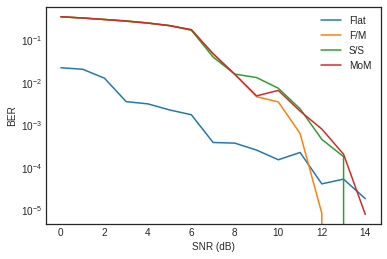

In [ ]:
for est, ber in reg_bers.items():
  plt.semilogy(range(15), ber, label=est)
plt.legend()
plt.xlabel('SNR (dB)')
plt.ylabel('BER')
plt.savefig('common_kfactor_BER_tx2high.pdf', dpi=150)

And Block Error Rate

Text(0, 0.5, 'BLER')

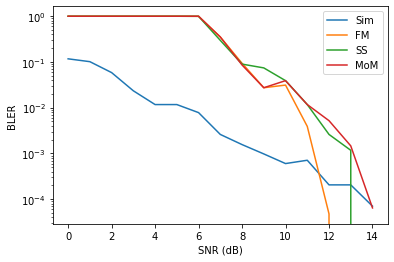

In [ ]:
for est, bler in reg_blers.items():
  plt.semilogy(range(15), bler, label=est)
plt.legend()
plt.xlabel('SNR (dB)')
plt.ylabel('BLER')
#plt.savefig('common_kfactor_BER_tx2high.pdf', dpi=150)

Results show that the measured CIRs always achieve the same result regardless of the estimator used.
We know that the three estimators 

In [ ]:
reg_bers_tx2high_ldpc = {'MoM':tx2high_regions_mom_ldpc_ber,
                        'FM': tx2high_regions_fm_ldpc_ber,
                        'SM': tx2high_regions_sm_ldpc_ber,
                         'Sim': tx2high_regions_sim_ldpc_ber}

BER results for same k factor 9.

Text(0, 0.5, 'BER')

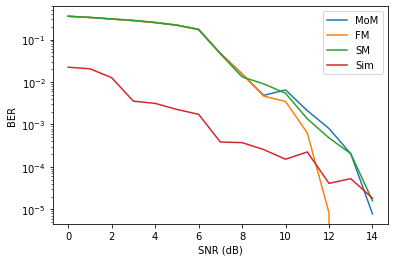

In [ ]:
for est, ber in reg_bers_tx2high_ldpc.items():
  plt.semilogy(range(15), ber, label=est)
plt.legend()
plt.xlabel('SNR (dB)')
plt.ylabel('BER')

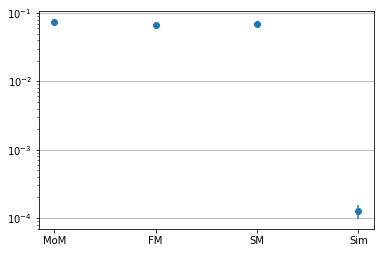

In [ ]:
reg_means = [np.mean(list(zip(*bers))[0]) for bers in reg_bers]
#means += [np.mean(list(zip(*dataset_ber))[0])]
stddevs = [np.std(list(zip(*bers))[0]) for bers in reg_bers]
#stddevs += [np.std(list(zip(*dataset_ber))[0])]
plt.errorbar([1,2,3,4], reg_means, yerr=stddevs, fmt='o')
plt.yscale('log')
_=plt.xticks([1,2,3,4], ['MoM', 'FM', 'SM', 'Sim'])
plt.grid(axis='y', which='major')

## Validation on FM regions

FM has a wide variation in the k factor

In [ ]:
from random import sample

In [ ]:
fm_ber_regions = {}
# First find the min-sized window
windows_sizes = []
for fm_k in range(0,11,2):
  fm_cirs = get_CIR_samples_for_regions(cir_iq_data,
                                        get_kfactor_regions(fm_k, kfactors[['FM', 'idx_start', 'idx_end']]))
  windows_sizes.append(len(fm_cirs))

for fm_k in range(0,11,2):
  fm_cirs = get_CIR_samples_for_regions(cir_iq_data,
                                        get_kfactor_regions(fm_k, kfactors[['FM', 'idx_start', 'idx_end']]))
  # Reduce all windows to the size of the minimum one by sampling
  model = CommsSystemDataset(params={"cir_data":sample(fm_cirs,  min(windows_sizes))})
  fm_regions_validation_ber = []
  for i in range(5):
    ber, _ = sionna.utils.sim_ber(model, [11], batch_size=256,
                                          max_mc_iter=1000, num_target_bit_errors=500)
    fm_regions_validation_ber.append(ber)
  fm_ber_regions[fm_k] = {'ber': fm_regions_validation_ber, 'region_size': len(fm_cirs)}

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     11.0 | 9.0770e-04 | 5.8594e-03 |         725 |      798720 |            3 |         512 |        24.8 |reached target bit errors
EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     11.0 | 1.7027e-03 | 1.1719e-02 |         680 |      399360 |            3 |         256 |        12.1 |reached target bit errors
EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
-------------------------------------------------------------------------------------------------------

Text(0, 0.5, 'BER')

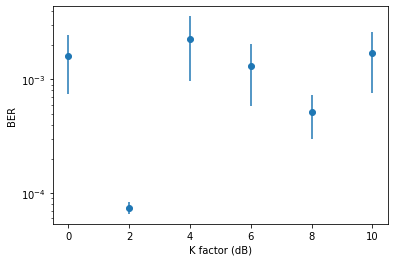

In [ ]:
plt.errorbar(range(0,11,2), [np.mean(fm_ber_regions[k]['ber']) for k in range(0,11,2)],
                            yerr=[np.std(fm_ber_regions[k]['ber']) for k in range(0,11,2)], fmt='o')
plt.yscale('log')
plt.xlabel('K factor (dB)')
plt.ylabel('BER')

Results above are for regions where the F/M estimator obtains the indicated k factor values, at an SNR of 11dB. Data is from the TX2high measurement.

Text(0, 0.5, 'Number of samples')

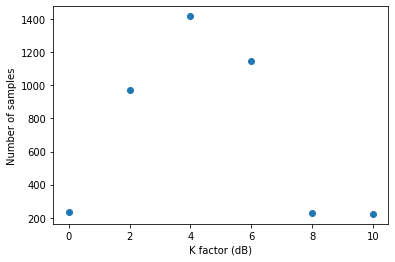

In [ ]:
plt.plot(range(0,11,2), [fm_ber_regions[k]['region_size'] for k in range(0,11,2)], 'o')
plt.xlabel('K factor (dB)')
plt.ylabel('Number of samples')

## Validation on all common k-factor regions

In [ ]:
def validate_ber_all(kfactor, dataset, kfactors, snr):
  """Compare the BER of measured vs simulated for all three estimators"""
  # MoM
  mom_cirs = get_CIR_samples_for_regions(dataset,
                  get_kfactor_regions(kfactor, kfactors[['MoM', 'idx_start', 'idx_end']]))
  print(f"MoM samples {len(mom_cirs)} for K={kfactor}")
  model = CommsSystemDataset(params={"cir_data":mom_cirs})
  mom_regions_validation_ber = []
  for i in range(5):
    ber, _ = sionna.utils.sim_ber(model, [snr], batch_size=256,
                                          max_mc_iter=1000, num_target_bit_errors=500)
    mom_regions_validation_ber.append(ber)

  # SM
  sm_cirs = get_CIR_samples_for_regions(dataset,
                  get_kfactor_regions(kfactor, kfactors[['SM', 'idx_start', 'idx_end']]))
  print(f"SM samples {len(sm_cirs)} for K={kfactor}")
  model = CommsSystemDataset(params={"cir_data":sm_cirs})
  sm_regions_validation_ber = []
  for i in range(5):
    ber, _ = sionna.utils.sim_ber(model, [snr], batch_size=256,
                                          max_mc_iter=1000, num_target_bit_errors=500)
    sm_regions_validation_ber.append(ber)

  # FM
  fm_cirs = get_CIR_samples_for_regions(dataset,
                  get_kfactor_regions(kfactor, kfactors[['FM', 'idx_start', 'idx_end']]))
  print(f"FM samples {len(fm_cirs)} for K={kfactor}")
  model = CommsSystemDataset(params={"cir_data":fm_cirs})
  fm_regions_validation_ber = []
  for i in range(5):
    ber, _ = sionna.utils.sim_ber(model, [snr], batch_size=256,
                                          max_mc_iter=1000, num_target_bit_errors=500)
    fm_regions_validation_ber.append(ber)

  ## Simulated
  #model = CommsSystemRiceChannel(params={"kfactor":kfactor})
  #sim_regions_validation_ber = []
  #for i in range(5):
  #  ber, _ = sionna.utils.sim_ber(model, [snr], batch_size=256,
  #                                        max_mc_iter=1000, num_target_bit_errors=500)
  #  sim_regions_validation_ber.append(ber)

  return {'MoM': mom_regions_validation_ber,
          'SM': sm_regions_validation_ber,
          'FM': fm_regions_validation_ber}
          #'Sim': sim_regions_validation_ber}

In [ ]:
def compare_lambda_windows(kfactor, kfactors):
  """Compare the lambda windows for a certain kfactor to measure overlapping"""
  # MoM
  mom_cirs = get_kfactor_regions(kfactor, kfactors[['MoM', 'idx_start', 'idx_end']])
  mom_windows = set(list(zip(*list(mom_cirs)))[0])
                     
  # SM
  sm_cirs = get_kfactor_regions(kfactor, kfactors[['SM', 'idx_start', 'idx_end']])
  sm_windows = set(list(zip(*list(sm_cirs)))[0])
  
  # FM
  fm_cirs = get_kfactor_regions(kfactor, kfactors[['FM', 'idx_start', 'idx_end']])
  fm_windows = set(list(zip(*list(fm_cirs)))[0])
  
  # Need to determine the size of the intersection between the windows
  # as well as the size of the unique samples
  intersection = mom_windows & sm_windows & fm_windows

  differences = {
      'MoM': mom_windows,
      'SM': sm_windows,
      'FM': fm_windows
  }

  return differences

In [ ]:
def validate_ber_all_snr_range(kfactor, dataset, kfactors, snr_range):
  """Compare the BER of measured vs simulated for all three estimators"""
  # MoM
  mom_cirs = get_CIR_samples_for_regions(dataset,
                  get_kfactor_regions(kfactor, kfactors[['MoM', 'idx_start', 'idx_end']]))
  print(f"MoM samples {len(mom_cirs)} for K={kfactor}")
  model = CommsSystemDataset(params={"cir_data":mom_cirs})
  mom_regions_validation_ber = sionna.utils.sim_ber(model, snr_range, batch_size=256,
                                          max_mc_iter=1000, num_target_bit_errors=500)

  # SM
  sm_cirs = get_CIR_samples_for_regions(dataset,
                  get_kfactor_regions(kfactor, kfactors[['SM', 'idx_start', 'idx_end']]))
  print(f"SM samples {len(sm_cirs)} for K={kfactor}")
  model = CommsSystemDataset(params={"cir_data":sm_cirs})
  sm_regions_validation_ber = sionna.utils.sim_ber(model, snr_range, batch_size=256,
                                          max_mc_iter=1000, num_target_bit_errors=500)

  # FM
  fm_cirs = get_CIR_samples_for_regions(dataset,
                  get_kfactor_regions(kfactor, kfactors[['FM', 'idx_start', 'idx_end']]))
  print(f"FM samples {len(fm_cirs)} for K={kfactor}")
  model = CommsSystemDataset(params={"cir_data":fm_cirs})
  fm_regions_validation_ber = sionna.utils.sim_ber(model, snr_range, batch_size=256,
                                          max_mc_iter=1000, num_target_bit_errors=500)

  ## Simulated
  #model = CommsSystemRiceChannel(params={"kfactor":kfactor})
  #sim_regions_validation_ber = []
  #for i in range(5):
  #  ber, _ = sionna.utils.sim_ber(model, [snr], batch_size=256,
  #                                        max_mc_iter=1000, num_target_bit_errors=500)
  #  sim_regions_validation_ber.append(ber)

  return {'MoM': mom_regions_validation_ber,
          'SM': sm_regions_validation_ber,
          'FM': fm_regions_validation_ber}
          #'Sim': sim_regions_validation_ber}

In [ ]:
common_kfactors = sorted([idx for idx, numregions in est_hists[1:] if numregions > 20])

In [ ]:
test_kfactors = [k_factor_bins[k] for k in range(common_kfactors[0], common_kfactors[-1], 2)][1:]

In [ ]:
test_kfactors = [7.58578830453847,
 8.58578830453847,
 9.58578830453847,
 10.58578830453847,
 11.58578830453847]

In [ ]:
common_kfactor_bers_validation = {}
for k in test_kfactors[4:]:
  common_kfactor_bers_validation[k] = validate_ber_all(k, cir_iq_data, kfactors, 10)

In [ ]:
overall_data_raw = [2.4064e-03, 4.5723e-03, 1.4173e-03, 3.3604e-03, 4.4346e-03, 1.8404e-04, 3.0799e-04, 2.4477e-04, 4.6074e-04, 4.4446e-04, 3.5532e-03, 2.6167e-03, 4.1642e-03, 2.6192e-03, 1.2720e-03, 3.6058e-04, 1.9707e-03, 7.5955e-04, 2.4239e-03, 5.6674e-04, 1.3046e-03, 2.1234e-03, 2.0207e-03, 2.1259e-03, 2.4614e-03, 5.1833e-03, 4.2919e-03, 6.6732e-03, 7.7399e-03, 3.4630e-03, 4.7013e-04, 1.9681e-03, 1.6714e-03, 2.2887e-03, 1.2896e-03, 3.1400e-04, 2.9829e-04, 1.3522e-04, 1.4974e-03, 3.3954e-04, 5.7742e-03, 5.8894e-03, 3.7260e-03, 4.1541e-03, 3.6483e-03, 5.6215e-03, 2.6718e-03, 2.9247e-03, 3.1150e-03, 3.3203e-03, 6.4303e-03, 4.5898e-03, 3.3328e-03, 4.0139e-03, 5.3586e-03, 2.4999e-05, 2.5675e-05, 4.7181e-05, 4.8023e-05, 4.5629e-05, 4.5573e-03, 4.3945e-03, 2.9723e-03, 3.5131e-03, 1.5625e-03, 1.9707e-03, 2.7444e-03, 1.3647e-03, 9.5903e-04, 1.6777e-03, 3.0048e-04, 4.5272e-04, 3.5557e-04, 5.8343e-04, 5.3836e-04, 3.6978e-05, 1.8724e-05, 1.2136e-05, 3.2695e-06, 4.0352e-06, 4.9104e-03, 3.7785e-03, 5.3861e-03, 4.5523e-03, 5.0656e-03, 3.7610e-03, 1.8329e-03, 5.2259e-03, 4.8177e-03, 2.3287e-03]
data_idx = 0
common_kfactor_bers_validation = {}
estimators = ['MoM', 'SM', 'FM', 'Sim']
for k in test_kfactors[:4]:
  common_kfactor_bers_validation[k] = {est:[] for est in estimators}
  for est in estimators:
    common_kfactor_bers_validation[k][est] = overall_data_raw[data_idx:data_idx+5]
    data_idx += 5

In [ ]:
pickle.dump(common_kfactor_bers_validation, open('common_k_factor_regions_ber_validation_TX2high__all_raw.pickle', 'wb'))

In [ ]:
def convert_to_nparray(ber_list):
  return list(map(lambda x: (x[0].numpy()[0], x[1].numpy()[0]), ber_list))

In [ ]:
convert_to_nparray(common_kfactor_bers_validation[7.58578830453847]['MoM'])

[(0.006861636513157895, 0.0263671875),
 (0.0060135690789473685, 0.02421875),
 (0.005982730263157895, 0.0203125),
 (0.0042807213345864665, 0.015625),
 (0.005645216557017544, 0.021484375)]

In [ ]:
ber_validation_numpy = {}
for k, vals in common_kfactor_bers_validation.items():
  ber_validation_numpy[k] = {est: convert_to_nparray(bers) for est, bers in vals.items()}

In [ ]:
pickle.dump(ber_validation_numpy, open('common_k_factor_regions_ber_validation_TX2high__numpy.pickle', 'wb'))

In [ ]:
[np.mean([val[0] for val in ber_validation_numpy[k]['MoM']]) for k in test_kfactors]

[0.005756774749373434,
 0.00589608787593985,
 0.006587342379385965,
 0.006309328007518797,
 0.0056952684445488715]

In [ ]:
print(f"{test_kfactors[0]:0.2f}")

7.59


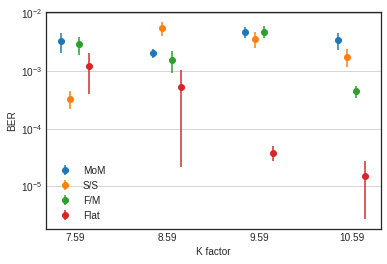

In [ ]:
types = ['MoM', 'SM', 'FM', 'Sim']
for idx, t in enumerate(types):
  plt.errorbar([(k-0.15+idx*0.1) for k in range(1, len(test_kfactors[:4])+1)],
               [np.mean(common_kfactor_bers_validation[k][t]) for k in test_kfactors[:4]],
               yerr=[np.std(common_kfactor_bers_validation[k][t]) for k in test_kfactors[:4]],
               label=t, fmt='o')
plt.yscale('log')
plt.xticks(range(1, len(test_kfactors[:4])+1), map(lambda x: f"{x:0.2f}", test_kfactors[:4]))
plt.grid(axis='y')
plt.xlabel('K factor')
plt.ylabel('BER')
plt.legend(['MoM', 'S/S', 'F/M', 'Flat'])
plt.savefig('common_regions_ber_snr10_tx2high.pdf', dpi=150)

Above compares the BER achievable for the measurement regions where the k factor was estimated at a given value, and the simulated flat fading Rice channel with same k factor

Evaluate the regions obtained per K factor to see if there are overlaps in the samples

In [ ]:
kfactor_regions = compare_lambda_windows(7.59, kfactors)

In [ ]:
test_k = compare_lambda_windows(9, kfactors)

In [ ]:
kfactor_regions_all = {k:compare_lambda_windows(k, kfactors) for k in test_kfactors}

## Comparing different channels

Testing over the entire channel. The kfactor distribution estimated by the MoM and S/S is similar for all channels, whereas the F/M varies greatly.

If the resulting BER is similar for all this means that the MoM and S/S are closest to truth.

In [ ]:
nist_mshop_high_k = pickle.load(open('PDP__GBurgD2_5GHz_TX1_vpol_run2.pickle', 'rb'))
nist_steam_low_k = pickle.load(open('PDP__Tx2_5G_Boiler_Xpol_run1.pickle', 'rb'))

In [ ]:
model = CommsSystemDataset(params={"cir_data":nist_mshop_high_k})
nist_mshop_high_k_ber, _ = sionna.utils.sim_ber(model, range(15), batch_size=256,
                                          max_mc_iter=1000, num_target_bit_errors=500)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 3.4879e-01 | 1.0000e+00 |      139294 |      399360 |          256 |         256 |        10.6 |reached target bit errors
      1.0 | 3.2663e-01 | 1.0000e+00 |      130442 |      399360 |          256 |         256 |        17.5 |reached target bit errors
      2.0 | 3.0438e-01 | 1.0000e+00 |      121559 |      399360 |          256 |         256 |        11.1 |reached target bit errors
      3.0 | 2.8049e-01 | 1.0000e+00 |      112016 |      399360 |          256 |         256 |        10.5 |reached target bit errors
      4.0 | 2.5457e-01 | 1.0000e+00 |      101667 |      399360 |          256 |         256 |        10.3 |reached target bit errors
      5.0 | 2.2508e-01 | 1.0000e+00 |       89888 |      399360 |          

In [ ]:
nist_mshop_high_k_ber = [3.4879e-01, 3.2663e-01, 3.0438e-01, 2.8049e-01, 2.5457e-01, 2.2508e-01, 1.9023e-01, 1.2096e-01, 2.1234e-03, 0.0000e+00, 0, 0, 0, 0, 0]

In [ ]:
nist_mshop_high_k_bler = [1,1,1,1,1,1,1,8.7891e-01,1.9531e-02,0,0,0,0,0,0]

In [ ]:
model = CommsSystemDataset(params={"cir_data":nist_steam_low_k, "num_taps": 90})
nist_steam_low_k_ber, _ = sionna.utils.sim_ber(model, range(15), batch_size=256,
                                          max_mc_iter=1000, num_target_bit_errors=500)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 3.4983e-01 | 1.0000e+00 |      139709 |      399360 |          256 |         256 |        11.1 |reached target bit errors
      1.0 | 3.2497e-01 | 1.0000e+00 |      129782 |      399360 |          256 |         256 |        11.2 |reached target bit errors
      2.0 | 3.0258e-01 | 1.0000e+00 |      120838 |      399360 |          256 |         256 |        11.1 |reached target bit errors
      3.0 | 2.7306e-01 | 1.0000e+00 |      109050 |      399360 |          256 |         256 |        11.1 |reached target bit errors
      4.0 | 2.4381e-01 | 1.0000e+00 |       97367 |      399360 |          256 |         256 |        11.0 |reached target bit errors
      5.0 | 2.0796e-01 | 1.0000e+00 |       83049 |      399360 |          

KeyboardInterrupt: ignored

In [ ]:
nist_steam_low_k_ber = [3.4983e-01, 3.2497e-01, 3.0258e-01, 2.7306e-01, 2.4381e-01, 2.0796e-01, 1.5307e-01, 1.1586e-02, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
nist_steam_low_k_bler = [1,1,1,1,1,1,1,1.3281e-01,0,0,0,0,0,0,0]

In [ ]:
model = CommsSystemDataset(params={"cir_data":cir_iq_data})
nist_mshop_mid_k, _ = sionna.utils.sim_ber(model, range(13), batch_size=256,
                                          max_mc_iter=1000, num_target_bit_errors=500)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 3.5234e-01 | 1.0000e+00 |      140711 |      399360 |          256 |         256 |        12.9 |reached target bit errors
      1.0 | 3.2934e-01 | 1.0000e+00 |      131527 |      399360 |          256 |         256 |        10.4 |reached target bit errors
      2.0 | 3.0693e-01 | 1.0000e+00 |      122577 |      399360 |          256 |         256 |        10.4 |reached target bit errors
      3.0 | 2.8026e-01 | 1.0000e+00 |      111926 |      399360 |          256 |         256 |        11.1 |reached target bit errors
      4.0 | 2.5032e-01 | 1.0000e+00 |       99967 |      399360 |          256 |         256 |        10.4 |reached target bit errors
      5.0 | 2.2251e-01 | 1.0000e+00 |       88862 |      399360 |          

In [ ]:
nist_mshop_mid_k, _ = sionna.utils.sim_ber(model, [13,14], batch_size=256,
                                          max_mc_iter=1000, num_target_bit_errors=500)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     13.0 | 1.2173e-04 | 9.0144e-04 |         632 |     5191680 |            3 |        3328 |       149.4 |reached target bit errors
     14.0 | 3.0281e-05 | 2.7253e-04 |         520 |    17172480 |            3 |       11008 |       452.1 |reached target bit errors


In [ ]:
nist_mshop_mid_k_ber = [3.5234e-01, 3.2934e-01, 3.0693e-01, 2.8026e-01, 2.5032e-01, 2.2251e-01, 1.7039e-01, 4.8638e-02, 1.2943e-02, 4.3495e-03, 2.0157e-03, 2.6292e-03, 3.4205e-04, 1.2173e-04, 3.0281e-05]

In [ ]:
nist_mshop_mid_k_bler = [1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 3.4375e-01, 7.8125e-02, 2.3438e-02, 1.1719e-02, 1.1719e-02, 1.5625e-03, 9.0144e-04, 2.7253e-04]


Other parameters for the channels used above:

GBurg D2 TX1 5GHz vpol
* mean FM K = 9.3
* mean delay = 135ns
* mean delay spread = 54ns

GBurg D2 TX2High 5GHz crosspol
* mean FM K = 4.2
* mean delay = 168ns
* mean delay spread = 78ns

Boiler TX2 5G crosspol
* mean FM K = -10
* mean delay = 140ns
* mean delay spread = 51ns


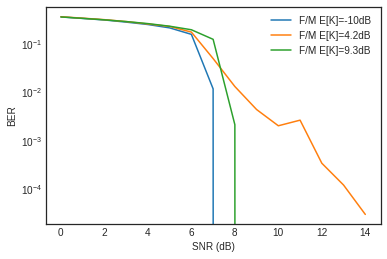

In [ ]:
plt.semilogy(range(15), nist_steam_low_k_ber, label='F/M E[K]=-10dB')
plt.semilogy(range(15), nist_mshop_mid_k_ber, label='F/M E[K]=4.2dB')
plt.semilogy(range(15), nist_mshop_high_k_ber, label='F/M E[K]=9.3dB')
plt.xlabel('SNR (dB)')
plt.ylabel('BER')
plt.legend()
plt.savefig('nist_channels_BER_comparison.pdf', dpi=150)

And Block Error Rate

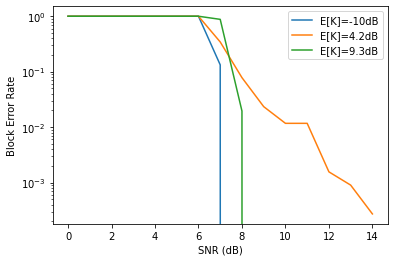

In [ ]:
plt.semilogy(range(15), nist_steam_low_k_bler, label='E[K]=-10dB')
plt.semilogy(range(15), nist_mshop_mid_k_bler, label='E[K]=4.2dB')
plt.semilogy(range(15), nist_mshop_high_k_bler, label='E[K]=9.3dB')
plt.xlabel('SNR (dB)')
plt.ylabel('Block Error Rate')
plt.legend()

Plot the BER of the simulated channel with NIST (FM) k factor 5

In [ ]:
sim_channel_ber['MoM'][0][0]

<tf.Tensor: shape=(15,), dtype=float64, numpy=
array([1.81537829e-01, 1.14103618e-01, 5.77713816e-02, 4.00219298e-02,
       1.23355263e-02, 7.56285244e-03, 2.61615954e-03, 1.41414029e-03,
       7.85269094e-04, 4.89233065e-04, 3.43098513e-04, 8.36759868e-05,
       4.93421053e-05, 2.17927632e-05, 1.85032895e-06])>

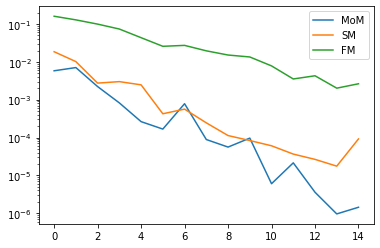

In [ ]:
for est, ber in sim_channel_ber.items():
  plt.semilogy(range(15), ber, label=est)
plt.legend()

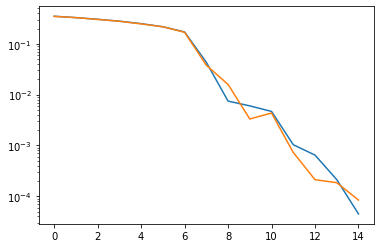

In [ ]:
plt.semilogy(range(15), ldpc_ber)
plt.semilogy(range(15), tx2low_ldpc_ber)

## Validation on a different channel

Load the channel CIRs

In [ ]:
nist_tx2_low = pickle.load(open('nist_experiments/PDP__GBurgD2_5GHz_TX2low_vpol_run1_allpoints.pickle', 'rb'))

Load the K factor distributions

In [ ]:
ch2_kfactors = pd.read_csv('nist_experiments/K-FactorGBurgD2_5GHz_TX2low_vpol_run1_pp.mat.csv', header=None)
ch2_kfactors.columns = ['MoM', 'SM', 'FM', 'samples', 'idx_start', 'idx_end', 'no']
del ch2_kfactors['no']

In [ ]:
ch2_k_factor_est_means = {est:np.mean(ch2_kfactors[est]) for est in ['MoM', 'SM', 'FM']}
print(ch2_k_factor_est_means)

{'MoM': 9.548795444302744, 'SM': 11.28147442943199, 'FM': 8.831874395025295}


Find

* K-factor common regions
* K-factor that is most common among all estimators.

In [ ]:
ch2_k_factor_range = (
    ch2_kfactors[['MoM', 'SM', 'FM']].min().min(),
    ch2_kfactors[['MoM', 'SM', 'FM']].max().max()
)

In [ ]:
ch2_k_factor_bins = np.arange(*ch2_k_factor_range, step=0.5)

In [ ]:
ch2_mom_hist = np.histogram(ch2_kfactors['MoM'], bins=ch2_k_factor_bins)
ch2_sm_hist = np.histogram(ch2_kfactors['SM'], bins=ch2_k_factor_bins)
ch2_fm_hist = np.histogram(ch2_kfactors['FM'], bins=ch2_k_factor_bins)

In [ ]:
ch2_est_hists = [(idx, sum([a,b,c])) if a*b*c != 0 else (idx, 0)
            for idx, (a,b,c) in enumerate(zip(ch2_mom_hist[0], ch2_sm_hist[0], ch2_fm_hist[0]))]

In [ ]:
ch2_est_hists.sort(key=lambda x:x[1],reverse=True)

In [ ]:
ch2_common_k_factor = ch2_k_factor_bins[ch2_est_hists[0][0]]

In [ ]:
ch2_common_k_factor

10.84649654503892

### Validation on all common k-factor regions

In [ ]:
ch2_common_kfactors = sorted([idx for idx, numregions in ch2_est_hists[1:] if numregions > 20])

In [ ]:
ch2_test_kfactors = [ch2_k_factor_bins[k] for k in range(ch2_common_kfactors[0], ch2_common_kfactors[-1], 2)][1:]

In [ ]:
ch2_test_kfactors

[8.84649654503892,
 9.84649654503892,
 10.84649654503892,
 11.84649654503892,
 12.84649654503892]

In [ ]:
ch2_common_kfactor_bers_validation_range = {}
for k in ch2_test_kfactors:
  ch2_common_kfactor_bers_validation_range[k] = validate_ber_all_snr_range(k, nist_tx2_low, ch2_kfactors, range(14))

MoM samples 1043 for K=8.84649654503892
EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 3.5304e-01 | 1.0000e+00 |      140991 |      399360 |          256 |         256 |        11.6 |reached target bit errors
      1.0 | 3.2934e-01 | 1.0000e+00 |      131524 |      399360 |          256 |         256 |        11.3 |reached target bit errors
      2.0 | 3.0442e-01 | 1.0000e+00 |      121572 |      399360 |          256 |         256 |        12.0 |reached target bit errors
      3.0 | 2.7959e-01 | 1.0000e+00 |      111658 |      399360 |          256 |         256 |        12.2 |reached target bit errors
      4.0 | 2.5144e-01 | 1.0000e+00 |      100414 |      399360 |          256 |         256 |        12.0 |reached target bit errors
      5.0 | 2.1625e-01 | 1.0000e+00

In [ ]:
result_txt_dat = [3.5304e-01, 3.2934e-01, 3.0442e-01, 2.7959e-01, 2.5144e-01, 2.1625e-01, 1.6951e-01, 4.6484e-02, 9.7381e-03, 3.2715e-03, 1.8279e-03, 5.5088e-04, 5.3899e-04, 1.2896e-04, 3.5086e-01, 3.3076e-01, 3.0614e-01, 2.7884e-01, 2.5281e-01, 2.1890e-01, 1.7418e-01, 4.8911e-02, 1.6489e-02, 7.5471e-03, 3.6458e-03, 1.7603e-03, 1.9807e-03, 2.9160e-04, 3.5232e-01, 3.3067e-01, 3.0495e-01, 2.7997e-01, 2.5100e-01, 2.1694e-01, 1.7065e-01, 3.8694e-02, 1.2818e-02, 3.6483e-03, 9.3274e-04, 7.8793e-04, 6.4979e-04, 8.5693e-05, 3.5166e-01, 3.2856e-01, 3.0664e-01, 2.7713e-01, 2.4953e-01, 2.1380e-01, 1.6920e-01, 3.3278e-02, 5.6566e-03, 2.0733e-03, 2.1935e-03, 1.5434e-04, 1.9036e-05, 3.1146e-06, 3.5092e-01, 3.3058e-01, 3.0606e-01, 2.7969e-01, 2.5019e-01, 2.1830e-01, 1.6724e-01, 3.9441e-02, 1.4250e-02, 5.8919e-03, 1.4774e-03, 6.5605e-04, 2.2741e-04, 4.6438e-05, 3.5041e-01, 3.2712e-01, 3.0429e-01, 2.7607e-01, 2.4945e-01, 2.1519e-01, 1.6582e-01, 4.0294e-02, 1.0577e-02, 2.2286e-03, 1.7453e-03, 4.3470e-04, 4.9913e-04, 5.1416e-04, 3.5260e-01, 3.2881e-01, 3.0491e-01, 2.8112e-01, 2.5031e-01, 2.1627e-01, 1.6631e-01, 4.5741e-02, 7.5696e-03, 5.7767e-03, 3.9213e-03, 7.7624e-04, 1.0705e-03, 2.5249e-04, 3.5443e-01, 3.3048e-01, 3.0600e-01, 2.7737e-01, 2.4906e-01, 2.1427e-01, 1.6407e-01, 4.0074e-02, 8.0354e-03, 6.1624e-03, 2.6417e-03, 1.3785e-03, 6.8359e-04, 2.6960e-04, 3.5171e-01, 3.2711e-01, 3.0395e-01, 2.7862e-01, 2.4818e-01, 2.1749e-01, 1.6740e-01, 3.8171e-02, 5.5063e-03, 2.7194e-03, 3.8587e-03, 1.5875e-03, 3.1175e-04, 2.8181e-05, 3.5214e-01, 3.2941e-01, 3.0617e-01, 2.7945e-01, 2.5054e-01, 2.1769e-01, 1.7195e-01, 4.3890e-02, 1.2540e-02, 2.8245e-03, 8.8266e-04, 1.5725e-03, 2.5666e-04, 1.9726e-04, 3.5089e-01, 3.2737e-01, 3.0597e-01, 2.7914e-01, 2.4559e-01, 2.1358e-01, 1.6195e-01, 4.0047e-02, 9.4025e-03, 2.3437e-03, 1.4022e-03, 6.6940e-04, 2.1075e-04, 1.2896e-04, 3.4991e-01, 3.2997e-01, 3.0382e-01, 2.8014e-01, 2.4794e-01, 2.1524e-01, 1.6844e-01, 3.6701e-02, 8.3884e-03, 1.4498e-03, 2.0608e-03, 3.2051e-04, 1.4863e-04, 4.1347e-05, 3.5211e-01, 3.3112e-01, 3.0503e-01, 2.7837e-01, 2.4929e-01, 2.1870e-01, 1.6580e-01, 3.7513e-02, 6.7508e-03, 6.1023e-03, 1.8955e-03, 7.6998e-04, 2.2402e-05]
data_idx = 0
tx2_low_common_kfactor_bers_validation = {}
estimators = ['MoM', 'SM', 'FM']
test_kfactors = sorted([11.84649654503892, 12.84649654503892, 8.84649654503892, 9.84649654503892, 10.84649654503892])[:-1]
for k in test_kfactors:
  tx2_low_common_kfactor_bers_validation[k] = {est:[] for est in estimators}
  for est in estimators:
    tx2_low_common_kfactor_bers_validation[k][est] = result_txt_dat[data_idx:data_idx+14]
    data_idx += 14

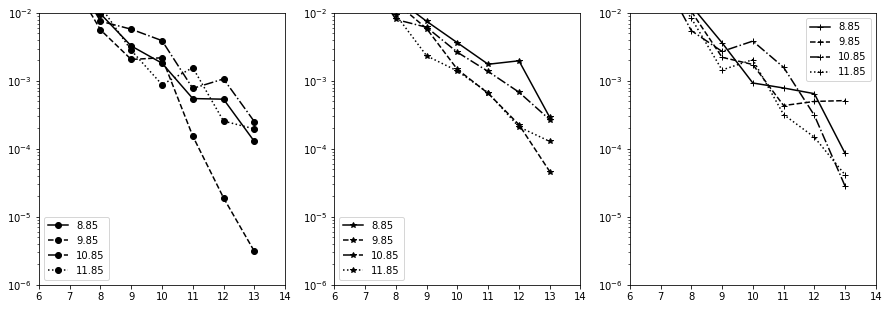

In [ ]:
est_style = {'MoM':'o', 'SM':'*', 'FM':'+'}
kfactor_style = ['-', '--', '-.', ':']
fig, ax = plt.subplots(1,3, figsize=(15,5))
for est_idx, est in enumerate(estimators):
  for kidx, kfactor in enumerate(test_kfactors):
    ax[est_idx].semilogy(tx2_low_common_kfactor_bers_validation[kfactor][est], f"{kfactor_style[kidx]}{est_style[est]}", color='black', label=f'{kfactor:0.2f}')
    ax[est_idx].set_xlim([6, 14])
    ax[est_idx].set_ylim([1e-6, 1e-2])
    ax[est_idx].legend()

In [ ]:
pickle.dump(ch2_common_kfactor_bers_validation_rem, open('tx2low_all_common_kfactors_rem.pickle', 'wb'))

In [ ]:
pickle.dump(ch2_common_kfactor_bers_validation_range, open('tx2low_all_common_kfactors_snr_range.pickle', 'wb'))

In [ ]:
ch2_common_kfactor_bers_validation.keys()

dict_keys([11.84649654503892, 12.84649654503892, 8.84649654503892, 9.84649654503892, 10.84649654503892])

In [ ]:
#ch2_ber_validation_numpy = {}
for k, vals in ch2_common_kfactor_bers_validation_rem.items():
  ch2_common_kfactor_bers_validation[k] = vals

In [ ]:
ch2_common_kfactor_bers_validation = {}
for key, vals in ch2_common_kfactor_bers_validation_rem.items():
  ch2_common_kfactor_bers_validation[key] = vals
for key, vals in ch2_common_kfactor_bers_validation_rest.items():
  ch2_common_kfactor_bers_validation[key] = vals

In [ ]:
pickle.dump(ch2_common_kfactor_bers_validation, open('tx2low_all_common_kfactors__raw.pickle', 'wb'))

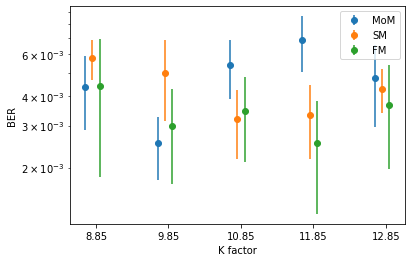

In [ ]:
types = ['MoM', 'SM', 'FM']#, 'Sim']
for idx, t in enumerate(types):
  plt.errorbar([(k-0.15+idx*0.1) for k in range(1, len(ch2_test_kfactors)+1)],
               [np.mean(ch2_common_kfactor_bers_validation[k][t]) for k in ch2_test_kfactors],
               yerr=[np.std(ch2_common_kfactor_bers_validation[k][t]) for k in ch2_test_kfactors],
               label=t, fmt='o')
plt.yscale('log')
plt.xticks(range(1, len(ch2_test_kfactors)+1), map(lambda x: f"{x:0.2f}", ch2_test_kfactors))
plt.grid(axis='y')
plt.xlabel('K factor')
plt.ylabel('BER')
plt.legend()